# 위험 측도
가치 평가 이외에 확률 과정 시뮬레이션의 중요한 응용 분야의 하나는 위험 관리 이다. 이 절에서는 오늘날 그뮹산업에서 가장 널리 쓰이는 두 가지 위험 측도를 계산/추정하는 법을 설명한다.

## VaR
Value at Risk는 가장 널리 사용되며 또한 가장 논란이 많은 위험 측도이다. 직관적이기 때문에 실무에서는 사랑받지만, 이론적 기반을 제대로 파악하지 못한다는 점에서 많은 비판을 받는다. VaR를 한마디로 설명하면 어떤 확률적인 신뢰도 하에서 특정 시간 내에 발생할 수 있는 화폐로 환산한 손실 가능 금액을 말한다.

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
s0 = 100
r = 0.05
sigma = 0.25
T = 30/365
I = 10000
sT = s0 *np.exp((r-0.5*sigma**2) *T
                   + sigma*np.sqrt(T)*npr.standard_normal(I))

In [3]:
R_gbm = np.sort(sT - s0)

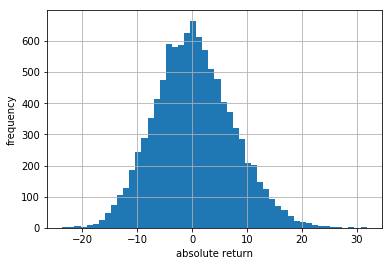

In [5]:
plt.hist(R_gbm, bins=50)
plt.xlabel('absolute return')
plt.ylabel('frequency')
plt.grid(True)

정렬된 결과를 담은 ndarray 객체만 있으면 나머지 작업은 scoreatpercentile 함수에 맡길 수 있다.

In [6]:
from scipy import stats
import scipy.stats as scs

In [8]:
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
var = scs.scoreatpercentile(R_gbm, percs)
print ("%16s %16s" % ('Confidence Level', 'Value-at-Risk'))
print (33*"-")
for pair in zip(percs, var):
    print ("%16.2f %16.3f" % (100 - pair[0], -pair[1]))

Confidence Level    Value-at-Risk
---------------------------------
           99.99           23.500
           99.90           20.785
           99.00           14.966
           97.50           12.930
           95.00           10.861
           90.00            8.632


머튼의 점프 확산 모형을 동적으로 시뮬레이션 해본다

In [12]:
M = 50
lamb = 0.75
mu = -0.6
delta = 0.25
dt = 30./365 / M
rj = lamb*(np.exp(mu + 0.5*delta**2)-1)
S= np.zeros((M+1, I))
S[0] = s0
sn1 = npr.standard_normal((M+1, I))
sn2 = npr.standard_normal((M+1, I))
poi = npr.poisson(lamb *dt, (M+1, I))
for t in range(1, M+1, 1):
    S[t] = S[t-1]*(np.exp((r-rj-0.5*sigma**2) *dt
                   + sigma * np.sqrt(dt)*sn1[t])
                   + (np.exp(mu + delta *sn2[t])-1)
                   * poi[t])
    S[t] = np.maximum(S[t],0)

In [13]:
R_jd = np.sort(S[-1] -s0)

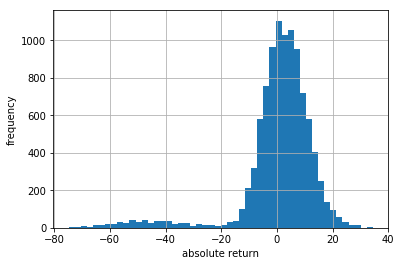

In [14]:
plt.hist(R_jd, bins=50)
plt.xlabel('absolute return')
plt.ylabel('frequency')
plt.grid(True)

이 경우에는 점프 요인이 음수이므로 정규분포 관점에서 보면 상당한 좌측 팻 테일을 가진다

In [15]:
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
var = scs.scoreatpercentile(R_jd, percs)
print ("%16s %16s" % ('Confidence Level', 'Value-at-Risk'))
print (33*"-")
for pair in zip(percs, var):
    print ("%16.2f %16.3f" % (100 - pair[0], -pair[1]))

Confidence Level    Value-at-Risk
---------------------------------
           99.99           73.121
           99.90           69.565
           99.00           56.027
           97.50           46.880
           95.00           25.199
           90.00            8.717


90% 신뢰도를 가진 30일 VaR 값은 이전의 결과와 거의 동일 하지만, 99%의 신뢰도 값은 기하 브라운 운동 모형의 세배 이상이다.  
이 결과는 표준적인 VaR 측도로 금융 시장에서 종종 발생하는 테일 리스크를 포착하지 못하는 문제를 보여준다.

In [16]:
percs = list(np.arange(0.0, 10.1, 0.1))
gbm_var = scs.scoreatpercentile(R_gbm, percs)
jd_var = scs.scoreatpercentile(R_jd, percs)


C:\Users\tohot\Anaconda3\envs\fba_1\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(-78.13554970409616, 0.0)

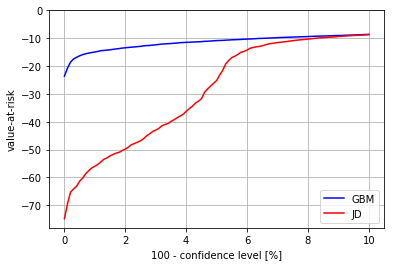

In [18]:
plt.plot(percs, gbm_var, 'b', lw=1.5, label='GBM')
plt.plot(percs, jd_var, 'r', lw=1.5, label='JD')
plt.legend(loc=4)
plt.xlabel('100 - confidence level [%]')
plt.ylabel('value-at-risk')
plt.grid(True)
plt.ylim(ymax=0.0)

## CVA
또 다른 위험 측도는 신용 VaR에서 파생된 Credit Value Adjustment이다. 신용 VaR는 거래 상대방이 이행의무를 다하지 않을 수 있는 가능성을 고려한 위험 측도이다. 파산의 경우 부도확률과 손실 수준의 두가지 가정이 필요하다. 좀 더 구체적으로 다음과 같은 인수를 가지는 BSM 모형을 다시 생각해보자


In [19]:
s0 = 100.
r = 0.05
sigma = 0.2
T = 1.
I = 100000
sT = s0 *np.exp((r-0.5*sigma**2) *T
                   + sigma*np.sqrt(T)*npr.standard_normal(I))

In [20]:
# 가장 단순한 경우로 손실 수준 L과 1년 부도 확률 p가 고정되어 있다고 한다.
L= 0.5
p = 0.01

In [22]:
# 포아송 분포를 이요하여 부도 시나리오 생성하기
D = npr.poisson(p*T, I)
D = np.where(D>1, 1, D)

In [23]:
# 부도가 발생하지 않은 경우에는 위험 중립 측도 하에 미래의 주가지수는 해당 자산의 현재 가치와 같아야한다.
np.exp(-r*T)* 1/I * np.sum(sT)

99.97601980859137

이 가정 하에서 신용 VaR은 다음과 같이 계산한다.

In [24]:
CVaR = np.exp(-r*T) *1/I *np.sum(L*D*sT)
CVaR

0.49431356692043205

같은 방법으로 신용 위험을 조정한 자산의 현재 가치는 다음과 같이 주어진다.

In [25]:
s0_CVA = np.exp(-r*T) *1/I * np.sum((1-L*D)*sT)
s0_CVA

99.4817062416709

이 값은 현재 자산 가치에서 신용 VaR값을 뺀 것과 거의 같아야 한다.

In [26]:
s0_adj = s0 - CVaR
s0_adj

99.50568643307957

In [27]:
# 시뮬레이션 하에서 신용 위험에 의한 손실 발생 횟수?
np.count_nonzero(L*D*sT)

996

(0.0, 175)

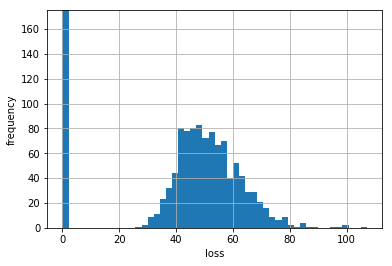

In [28]:
# 위험 중립 하에서 부도로 인한 손실 분포
plt.hist(L*D*sT, bins=50)
plt.xlabel('loss')
plt.ylabel('frequency')
plt.grid(True)
plt.ylim(ymax = 175)

In [29]:
# 이 경우의 유러피안 콜 옵션의 가치
K = 100.
hT = np.maximum(sT - K, 0)
C0 = np.exp(-r*T) * 1/I * np.sum(hT)
C0

10.437598479279476

In [30]:
# 콜 옵션의 VaR
CVaR = np.exp(-r*T)* 1/I * np.sum(L*D*hT)
CVaR

0.05082792001933739

In [32]:
# 조정된 옵션 가치
C0_CVA = np.exp(-r*T) *1/I * np.sum((1-L*D)*hT)
C0_CVA

10.386770559260139

In [33]:
# 손실횟수
np.count_nonzero(L*D*hT)

525

In [34]:
# 부도횟수
np.count_nonzero(D)

996

자산 자체의 경우와 비교하면 옵션 가치 평가는 약간 다른 특성을 보인다. 자산의 경우에는 부도로 인한 손실이 1000회 이상이었는데 옵션의 경우에는 500회 약간 넘을 뿐이다. 이는 옵션의 만기 페이오프가 그 자체로 0이 될 확률이 높기 때문이다.

In [35]:
# 페이오프가 없는 경우
I - np.count_nonzero(hT)

44025

(0.0, 350)

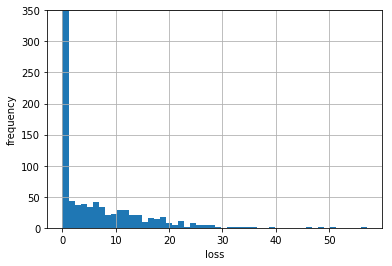

In [36]:
# 콜옵션에서 위험 중립 가정하 부도로 인한 손실
plt.hist(L*D*hT, bins=50)
plt.xlabel('loss')
plt.ylabel('frequency')
plt.grid(True)
plt.ylim(ymax = 350)